In [1]:
import rasterio as rio
import boto3
import s3fs

import geopandas as gpd

import pandas as pd

from shapely import geometry
from shapely import ops

import matplotlib.pyplot as plt
from cmr import GranuleQuery

MODIS_CMR_COLLECTION_NAME = "MODISA_L3m_CHL"
MODIS_YEARS = {
    'start': pd.to_datetime("20020704"), 
    'end': pd.to_datetime("20210101")
}

## Download MODIS data to validate MHWs

We need to download MODIS Chlorophyll-a data in order to validate physiological responses to MHWs. MODIS captures much of the planet every day, so we can relatively easily try to assess all detected MHWs. There are a few caveats to this:
* MODIS measurement swaths do not overlap -- while all latitudes are covered by MODIS measurements, all longitudes are not, in a single day. 
* There are 8 day gridded products which are likely to have full-planet coverage, so we could use those (+ limit MHW length to 8 days minimum?)
* we could also try to get all MODIS products for the duration of a MHW and just aggregate the ones that contain data

In [2]:
plankton = pd.read_csv("../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

plankton = plankton[
    (plankton.habitat == 'marine') & 
    (plankton.curvequal == 'good')
]


In [3]:
mhws = pd.read_csv("../../analysis/isolate_performance_withnegative.csv", parse_dates = ['peak_date', 'start_date'])
mhws.head()

,Unnamed: 0,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins
0,0,-74.875,164.625,1,4.0,3.433027,1.303966,0.429128,0.237193,0.078059,...,1.297811,9.0,1,1,-1.202301,1986-12-31,536457600000000000,0.846135,"(-75.026, -59.75]","(0.639, 91.25]"
1,1,-74.875,164.625,1,5.0,6.265167,1.269172,0.417678,0.287250,0.094533,...,1.528319,16.0,21,32,-1.103370,1987-01-21,539136000000000000,0.815611,"(-75.026, -59.75]","(0.639, 91.25]"
2,2,-74.875,164.625,1,11.0,9.585366,1.713322,0.563845,0.035686,0.011744,...,0.187730,18.0,232,244,-1.168743,1988-08-19,588988800000000000,0.979598,"(-75.026, -59.75]","(181.5, 271.75]"
3,3,-74.875,164.625,1,14.0,10.139295,1.711648,0.563294,0.033256,0.010944,...,0.174102,19.0,196,201,-1.181397,1989-07-15,616896000000000000,0.980941,"(-75.026, -59.75]","(181.5, 271.75]"
4,4,-74.875,164.625,1,37.0,6.210158,1.715494,0.564560,0.029738,0.009786,...,0.156030,12.0,215,220,-1.219370,1995-08-03,807840000000000000,0.982961,"(-75.026, -59.75]","(181.5, 271.75]"


## Analysis Design
* Grab a set of isolates that are not too close to shore (how close?)

In [54]:
len(plankton['isolate.code'].unique())
isolate_locations = gpd.GeoSeries(
    [
        geometry.Point(p['isolation.longitude'], p['isolation.latitude'])
        for _, p in plankton.dropna(axis=0, subset=['isolation.longitude', 'isolation.latitude']).groupby('isolate.code').head(1)[['isolation.latitude', 'isolation.longitude']].iterrows()
    ],
    crs={'init': 'epsg:4326'}
)

In [56]:
isolate_locations

0     POINT (164.50000 -74.83000)
1     POINT (110.48000 -66.28000)
2     POINT (-64.06000 -64.78000)
3      POINT (62.00000 -58.00000)
4     POINT (168.12000 -46.98000)
                 ...             
84    POINT (174.12000 -41.20000)
85    POINT (173.99000 -41.13000)
86    POINT (174.75000 -36.25000)
87    POINT (174.75000 -36.25000)
88       POINT (5.54000 60.17000)
Length: 89, dtype: geometry

In [57]:
landmasses = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip", crs='EPSG:4326').to_crs(epsg=3857)

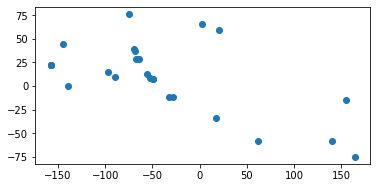

In [61]:
isolate_locations.iloc[isolate_locations.to_crs(epsg=3857).distance(landmasses.cascaded_union).sort_values(ascending=False).head(25).index].plot()

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,minqual,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis
0,1,"Terra Nova Bay, Ross Sea, Antarctica",-74.83,164.50,marine,Koliella antarctica strain SAG 2030,Koliella antarctica,NaN,NaN,SAG 2030,...,good,good,good,-40.320257,-0.007766,1.0,1.0,1.0,1.0,1.0
2,3,"Windmill Islands, Antarctica",-66.28,110.48,marine,Klebsormidium strain UMACC 227,Klebsormidium,NaN,NaN,UMACC 227,...,good,good,good,277.833630,0.010216,0.0,0.0,0.0,0.0,0.0
3,5,"Arthur Harbor, Palmer Station, Antarctica",-64.78,-64.06,marine,Phaeocystis antarctica strain CCMP 1871,Phaeocystis antarctica,NaN,NaN,CCMP 1871,...,good,good,good,-5.192227,-0.005703,1.0,1.0,1.0,1.0,1.0
8,11,"Southern Ocean, Indian sector",-58.00,62.00,marine,Pseudo-nitzschia turgiduloides,Pseudo-nitzschia turgiduloides,Nitzschia turgiduloides,NaN,NaN,...,good,good,good,-4.634105,-0.004083,1.0,1.0,1.0,1.0,1.0
11,14,"Big Glory Bay, New Zealand",-46.98,168.12,marine,Emiliania huxleyi,Emiliania huxleyi,Coccolithus huxleyi,NaN,NaN,...,good,good,good,-111.068341,-0.013906,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,570,"Ruakaka Bay, Marlborough Sounds, New Zealand",-41.20,174.12,marine,Chrysochromulina ericina,Chryosochromulina ericina,NaN,NaN,NaN,...,good,good,good,-145.668220,-0.019616,1.0,1.0,1.0,1.0,1.0
424,571,"Elie Bay, Marlborough Sounds, New Zealand",-41.13,173.99,marine,Chrysochromulina hirta,Chryosochromulina hirta,NaN,NaN,NaN,...,good,good,good,-131.910963,-0.019797,1.0,1.0,1.0,1.0,1.0
425,572,"Pakiri beach, Hauraki Gulf, New Zealand",-36.25,174.75,marine,Chrysochromulina acantha,Chryosochromulina acantha,NaN,NaN,NaN,...,good,good,good,-129.965038,-0.019777,1.0,1.0,1.0,1.0,1.0
426,573,"Pakiri beach, Hauraki Gulf, New Zealand",-36.25,174.75,marine,Chrysochromulina simplex,Chryosochromulina simplex,NaN,NaN,NaN,...,good,good,good,-122.268090,-0.015512,1.0,1.0,1.0,1.0,1.0
